In [1]:
from sklearn import metrics
import numpy as np
import pandas as pd
import cv2
import os 
import shutil
import tensorflow as tf
from tensorflow import keras
# import keras
import tensorflow.keras.backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
import gc
import sklearn as sk
from tqdm import tqdm_notebook
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
train_csv = pd.read_csv('../input/plantseedlings/plant-seeedlings-dataset-v2/train_csv.csv')
test_csv = pd.read_csv('../input/plantseedlings/plant-seeedlings-dataset-v2/test_csv.csv')

In [3]:
train_csv.head()

,image_name,label
0,Small-flowered Cranesbill/506.png,10
1,Scentless Mayweed/498.png,8
2,Black-grass/293.png,0
3,Cleavers/340.png,2
4,Fat Hen/498.png,5


In [4]:
random_seed = 1337

In [5]:
batch_size = 64
image_size = 224

In [6]:
imageDataGenerator = keras.preprocessing.image.ImageDataGenerator(
                                                                  featurewise_center=False, 
                                                                samplewise_center=False,
                                                                  featurewise_std_normalization=False, 
                                                                  samplewise_std_normalization=False,
                                                                zca_whitening=False,
                                                                  zca_epsilon=1e-06, 
                                                                  rotation_range=40, 
                                                                  width_shift_range=0.4, 
                                                                  height_shift_range=0.4, 
                                                                  brightness_range=(0.0,2.0), 
                                                                  shear_range=0.4, zoom_range=0.4,
                                                                  channel_shift_range=0.0, 
                                                                  fill_mode='nearest',
                                                                  cval=0.0, horizontal_flip=True,
                                                                  vertical_flip=True, 
                                                              rescale=1/255,
                                                              preprocessing_function=None, 
                                                              data_format=None, 
                                                            validation_split=0.,
                                                              dtype=None) 

In [7]:
classes = [str(i) for i in range(0,12)]

In [8]:
train_csv.label = train_csv.label.astype(str)
test_csv.label = test_csv.label.astype(str)

In [9]:
test_imageDataGenerator = keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False,
                                                                  featurewise_std_normalization=False, 
                                                                  samplewise_std_normalization=False, zca_whitening=False,
                                                                  zca_epsilon=1e-06, 
                                                                  rotation_range=0, 
                                                                  width_shift_range=0.0, height_shift_range=0.0, 
                                                                  brightness_range=None, 
                                                                  shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, 
                                                                  fill_mode='nearest',
                                                                  cval=0.0, horizontal_flip=False, vertical_flip=False, 
                                                                  rescale=1/255,
                                                                  preprocessing_function=None, 
                                                                  data_format=None, 
                                                                validation_split=0.0, dtype=None)

In [10]:
def get_generator():
    trainDataGenerator = imageDataGenerator.flow_from_dataframe(train_csv,
                                                        '../input/plantseedlings/plant-seeedlings-dataset-v2/images/',
                                                        x_col='image_name',
                                                        y_col='label',
                                                        target_size=(image_size, image_size), color_mode='rgb',
                                                        classes=classes, class_mode='categorical', batch_size=batch_size, 
                                                        shuffle=True, seed=random_seed,
                                                        save_to_dir=None, 
                                                        save_prefix='', save_format='png',
                                                        subset='training', interpolation='nearest')
    validDataGenerator = imageDataGenerator.flow_from_dataframe(train_csv,  
                                                        '../input/plantseedlings/plant-seeedlings-dataset-v2/images/',
                                                        x_col='image_name',
                                                        y_col='label',
                                                        target_size=(image_size, image_size), color_mode='rgb',
                                                        classes=classes, class_mode='categorical', batch_size=batch_size, 
                                                        shuffle=True, seed=random_seed,
                                                        save_to_dir=None, 
                                                        save_prefix='', save_format='png',
                                                        subset='validation', 
                                                        interpolation='nearest')

    testDataGenerator = test_imageDataGenerator.flow_from_dataframe(test_csv, 
                                                        '../input/plantseedlings/plant-seeedlings-dataset-v2/images/',
                                                       x_col='image_name', y_col='label',
                                                       target_size=(image_size, image_size),
                                                       color_mode='rgb', 
                                                       classes=classes, 
                                                       class_mode='categorical',
                                                       batch_size=batch_size, 
                                                        shuffle=False, seed=None, 
                                                       save_to_dir=None, 
                                                        save_prefix='', save_format='png',
                                                       subset=None, interpolation='nearest')
    return trainDataGenerator,validDataGenerator,testDataGenerator

In [11]:
def get_bottlenet(alpha=0.5):
    inputs = keras.layers.Input(shape=(image_size,image_size,3),name='input_1')
    net = keras.layers.ZeroPadding2D(padding=(3,3),name='zero_padding2d_1')(inputs)
    net = keras.layers.Conv2D(filters=64, kernel_size=(7,7), strides=(2,2),
                             padding='valid', name='conv1/conv')(net)
    net = keras.layers.BatchNormalization(name='conv1/bn')(net)
    net = keras.layers.ReLU(name='conv1/relu')(net)
    net = keras.layers.ZeroPadding2D(padding=(1,1),name='zero_padding2d_2')(net)
    se = keras.layers.GlobalAveragePooling2D(name='transform2_pool')(net)

    net = keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid',
                                   name='pool1')(net)
    se = keras.layers.GlobalAveragePooling2D(name='transform2_pool')(net)
    for i in range(int(6*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32,kernel_size=(3,3), strides=(1, 1), 
                                    padding='same',
                                    name='conv2_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv2_block{}_concat'.format(i))([net,block])    
    net = keras.layers.BatchNormalization(name='pool2_bn')(net) 
    net = keras.layers.ReLU(name='pool2_relu')(net)
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform2_dense1')(se)
    net = keras.layers.Multiply(name='transform2_multiply')([net,eq])

    net = keras.layers.Conv2D(filters=net.shape[-1]//2,kernel_size=(1,1),strides=(1,1),
                             padding='same',name='pool2_conv')(net)
    net = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),
                                        name='pool2_pool')(net)
    se = keras.layers.GlobalAveragePooling2D(name='transform3_pool')(net)

    for i in range(int(12*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), strides=(1, 1), 
                                    padding='same',
                                    name='conv3_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv3_block{}_concat'.format(i))([net,block])
    net = keras.layers.BatchNormalization(name='pool3_bn')(net) 
    net = keras.layers.ReLU(name='pool3_relu')(net)
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform3_dense1')(se)
    net = keras.layers.Multiply(name='transform3_multiply')([net,eq])

    net = keras.layers.Conv2D(filters=net.shape[-1]//2,kernel_size=(1,1),strides=(1,1),
                             padding='same',name='pool3_conv')(net)
    net = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),
                                    name='pool3_pool')(net)
    se = keras.layers.GlobalAveragePooling2D(name='transform4_pool')(net)

    for i in range(int(24*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), strides=(1, 1), 
                                    padding='same',
                                    name='conv4_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv4_block{}_concat'.format(i))([net,block])
    net = keras.layers.BatchNormalization(name='pool4_bn')(net) 
    net = keras.layers.ReLU(name='pool4_relu')(net)
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform4_dense1')(se)
    net = keras.layers.Multiply(name='transform4_multiply')([net,eq])

    net = keras.layers.Conv2D(filters=net.shape[-1]//2,kernel_size=(1,1),strides=(1,1),
                             padding='same',name='pool4_conv')(net)
    net = keras.layers.AveragePooling2D(pool_size=(2,2),strides=(2,2),
                                        name='pool4_pool')(net)
    se = keras.layers.GlobalAveragePooling2D(name='transform5_pool')(net)
    for i in range(int(16*alpha)):
        block = net
        block = keras.layers.SeparableConv2D(filters=32, kernel_size=(3,3), strides=(1, 1), 
                                    padding='same',
                                    name='conv5_block{}_2_sepconv'.format(i))(block)
        net = keras.layers.Concatenate(name='conv5_block{}_concat'.format(i))([net,block])
       
    eq = keras.layers.Dense(units=net.shape[-1],activation='sigmoid',
                            name='transform5_dense1')(se)
    net = keras.layers.Multiply(name='transform5_multiply')([net,eq])
    net = keras.layers.BatchNormalization(name='bn')(net)
    net = keras.layers.ReLU(name='relu')(net)
    model = keras.Model(inputs=inputs,outputs=net)
    return model

def get_model(alpha=0.5):
    bottlenet = get_bottlenet(alpha=alpha)
    net = keras.layers.GlobalAveragePooling2D(name='global_pool')(bottlenet.output)
    net = keras.layers.Dropout(rate=0.4,name='dropout1')(net)
    net = keras.layers.Dropout(rate=0.4,name='dropout2')(net)
    output = keras.layers.Dense(units=len(classes),activation='softmax',
                             name='flower_prediction')(net)
    model = keras.Model(inputs=bottlenet.input,outputs=output,name='model')
    return model

In [12]:
#callbacks

modelcheckpoint = keras.callbacks.ModelCheckpoint('model.h5',
                                                  monitor='val_acc', 
                                                  verbose=0, save_best_only=True,
                                                  save_weights_only=False, mode='auto', period=1)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0,
                                              patience=50, verbose=1, mode='auto',
                                              baseline=None, restore_best_weights=False)
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32,
                                          write_graph=True, write_grads=False, write_images=False,
                                          embeddings_freq=0, embeddings_layer_names=None,
                                          embeddings_metadata=None, embeddings_data=None,
                                          update_freq='epoch')
learn_scheduler1 = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                  patience=20,
                                  verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)



csvlog = keras.callbacks.CSVLogger('train.log', separator=',', append=False)

callbacks = [learn_scheduler1,modelcheckpoint,earlystopping]
epochs = 1000

In [13]:
import os 
os.environ['TF_KERAS'] = '1'

In [14]:
!pip install keras-rectified-adam
from keras_radam import RAdam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=e88e82d85cc742852bcb517ddf3faa5197d1aaa07d8c77065f2a4264e66d7f1c
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [15]:
import tensorflow as tf


@tf.keras.utils.register_keras_serializable(package='Addons')
class Lookahead(tf.keras.optimizers.Optimizer):
    """This class allows to extend optimizers with the lookahead mechanism.
    The mechanism is proposed by Michael R. Zhang et.al in the paper
    [Lookahead Optimizer: k steps forward, 1 step back]
    (https://arxiv.org/abs/1907.08610v1). The optimizer iteratively updates two
    sets of weights: the search directions for weights are chosen by the inner
    optimizer, while the "slow weights" are updated each `k` steps based on the
    directions of the "fast weights" and the two sets of weights are
    synchronized. This method improves the learning stability and lowers the
    variance of its inner optimizer.
    Example of usage:
    ```python
    opt = tf.keras.optimizers.SGD(learning_rate)
    opt = tfa.optimizers.Lookahead(opt)
    ```
    """

    def __init__(self,
                 optimizer,
                 sync_period=6,
                 slow_step_size=0.5,
                 name="Lookahead",
                 **kwargs):
        r"""Wrap optimizer with the lookahead mechanism.
        Args:
            optimizer: The original optimizer that will be used to compute
                and apply the gradients.
            sync_period: An integer. The synchronization period of lookahead.
                Enable lookahead mechanism by setting it with a positive value.
            slow_step_size: A floating point value.
                The ratio for updating the slow weights.
            name: Optional name for the operations created when applying
                gradients. Defaults to "Lookahead".
            **kwargs: keyword arguments. Allowed to be {`clipnorm`,
                `clipvalue`, `lr`, `decay`}. `clipnorm` is clip gradients
                by norm; `clipvalue` is clip gradients by value, `decay` is
                included for backward compatibility to allow time inverse
                decay of learning rate. `lr` is included for backward
                compatibility, recommended to use `learning_rate` instead.
        """
        super(Lookahead, self).__init__(name, **kwargs)

        if isinstance(optimizer, str):
            optimizer = tf.keras.optimizers.get(optimizer)
        if not isinstance(optimizer, tf.keras.optimizers.Optimizer):
            raise TypeError(
                "optimizer is not an object of tf.keras.optimizers.Optimizer")

        self._optimizer = optimizer
        self._set_hyper('sync_period', sync_period)
        self._set_hyper('slow_step_size', slow_step_size)
        self._initialized = False

    def _create_slots(self, var_list):
        self._optimizer._create_slots(var_list=var_list)  # pylint: disable=protected-access
        for var in var_list:
            self.add_slot(var, 'slow')

    def _create_hypers(self):
        self._optimizer._create_hypers()  # pylint: disable=protected-access

    def _prepare(self, var_list):
        return self._optimizer._prepare(var_list=var_list)  # pylint: disable=protected-access

    def apply_gradients(self, grads_and_vars, name=None):
        self._optimizer._iterations = self.iterations  # pylint: disable=protected-access
        return super(Lookahead, self).apply_gradients(grads_and_vars, name)

    def _init_op(self, var):
        slow_var = self.get_slot(var, 'slow')
        return slow_var.assign(
            tf.where(
                tf.equal(self.iterations,
                         tf.constant(0, dtype=self.iterations.dtype)),
                var,
                slow_var,
            ),
            use_locking=self._use_locking)

    def _look_ahead_op(self, var):
        var_dtype = var.dtype.base_dtype
        slow_var = self.get_slot(var, 'slow')
        local_step = tf.cast(self.iterations + 1, tf.dtypes.int64)
        sync_period = self._get_hyper('sync_period', tf.dtypes.int64)
        slow_step_size = self._get_hyper('slow_step_size', var_dtype)
        step_back = slow_var + slow_step_size * (var - slow_var)
        sync_cond = tf.equal(
            tf.math.floordiv(local_step, sync_period) * sync_period,
            local_step)
        with tf.control_dependencies([step_back]):
            slow_update = slow_var.assign(
                tf.where(
                    sync_cond,
                    step_back,
                    slow_var,
                ),
                use_locking=self._use_locking)
            var_update = var.assign(
                tf.where(
                    sync_cond,
                    step_back,
                    var,
                ),
                use_locking=self._use_locking)
        return tf.group(slow_update, var_update)

    @property
    def weights(self):
        return self._weights + self._optimizer.weights

    def _resource_apply_dense(self, grad, var):
        init_op = self._init_op(var)
        with tf.control_dependencies([init_op]):
            train_op = self._optimizer._resource_apply_dense(grad, var)  # pylint: disable=protected-access
            with tf.control_dependencies([train_op]):
                look_ahead_op = self._look_ahead_op(var)
        return tf.group(init_op, train_op, look_ahead_op)

    def _resource_apply_sparse(self, grad, var, indices):
        init_op = self._init_op(var)
        with tf.control_dependencies([init_op]):
            train_op = self._optimizer._resource_apply_sparse(  # pylint: disable=protected-access
                grad, var, indices)
            with tf.control_dependencies([train_op]):
                look_ahead_op = self._look_ahead_op(var)
        return tf.group(init_op, train_op, look_ahead_op)

    def get_config(self):
        config = {
            'optimizer': tf.keras.optimizers.serialize(self._optimizer),
            'sync_period': self._serialize_hyperparameter('sync_period'),
            'slow_step_size': self._serialize_hyperparameter('slow_step_size'),
        }
        base_config = super(Lookahead, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @property
    def learning_rate(self):
        return self._optimizer._get_hyper('learning_rate')

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self._optimizer._set_hyper('learning_rate', learning_rate)

    @property
    def lr(self):
        return self.learning_rate

    @lr.setter
    def lr(self, lr):
        self.learning_rate = lr

    @classmethod
    def from_config(cls, config, custom_objects=None):
        optimizer = tf.keras.optimizers.deserialize(
            config.pop('optimizer'),
            custom_objects=custom_objects,
        )
        return cls(optimizer, **config)

In [16]:
trainDataGenerator,validDataGenerator,testDataGenerator = get_generator()

Found 4431 validated image filenames belonging to 12 classes.
Found 0 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


In [17]:
desnet121_model = get_model()

In [18]:
# desnet121_model.summary()

In [19]:
for layer in desnet121_model.layers:
    if hasattr(layer,'kernel_initializer'):
        layer.kernel_initializer = keras.initializers.he_normal()
    if hasattr(layer,'depthwise_initializer'):
        layer.depthwise_initializer = keras.initializers.he_normal()
    if hasattr(layer, 'pointwise_initializer'):
        layer.pointwise_initializer = keras.initializers.he_normal()

weight_decay = 1e-4
for layer in desnet121_model.layers:
    if hasattr(layer,'kernel_regularizer'):
        layer.kernel_regularizer = keras.regularizers.l2(weight_decay)
    if hasattr(layer,'depthwise_regularizer'):
        layer.depthwise_regularizer = keras.regularizers.l2(weight_decay)
    if hasattr(layer,'pointwise_regularizer'):
        layer.pointwise_regularizer = keras.regularizers.l2(weight_decay)
    if hasattr(layer,'gamma_regularizer'):
        layer.gamma_regularizer = keras.regularizers.l2(weight_decay)
    if hasattr(layer,'beta_regularizer'):
        layer.beta_regularizer = keras.regularizers.l2(weight_decay)

In [20]:
desnet121_model.compile(loss=keras.losses.categorical_crossentropy,
                            optimizer=Lookahead(RAdam(lr=0.01)),metrics=['acc'])

In [21]:
%%time
epoch = 600
desnet121_history = desnet121_model.fit_generator(trainDataGenerator, epochs=epoch, 
                          verbose=1, callbacks=callbacks, 
                          validation_data=testDataGenerator, 
                          class_weight=None) 
desnet121_model.load_weights('model.h5')
print(desnet121_model.evaluate_generator(trainDataGenerator,verbose=0))
# print(desnet121_model.evaluate_generator(validDataGenerator,verbose=0))
print(desnet121_model.evaluate_generator(testDataGenerator,verbose=0))

Train for 70 steps, validate for 18 steps
Epoch 1/600
70/70 [==============================] - 157s 2s/step - loss: 2.4302 - acc: 0.1923 - val_loss: 2.4680 - val_acc: 0.0930
Epoch 2/600
70/70 [==============================] - 105s 2s/step - loss: 1.9805 - acc: 0.3275 - val_loss: 2.4672 - val_acc: 0.1327
Epoch 3/600
70/70 [==============================] - 105s 1s/step - loss: 1.7801 - acc: 0.3740 - val_loss: 2.5682 - val_acc: 0.1327
Epoch 4/600
70/70 [==============================] - 105s 1s/step - loss: 1.6711 - acc: 0.4250 - val_loss: 2.7477 - val_acc: 0.1327
Epoch 5/600
70/70 [==============================] - 105s 2s/step - loss: 1.5816 - acc: 0.4586 - val_loss: 2.2442 - val_acc: 0.1805
Epoch 6/600
70/70 [==============================] - 105s 2s/step - loss: 1.5019 - acc: 0.4798 - val_loss: 1.5542 - val_acc: 0.4116
Epoch 7/600
70/70 [==============================] - 105s 2s/step - loss: 1.4522 - acc: 0.5078 - val_loss: 3.6153 - val_acc: 0.2067
Epoch 8/600
70/70 [===============

Text(0, 0.5, '% Accuracy')

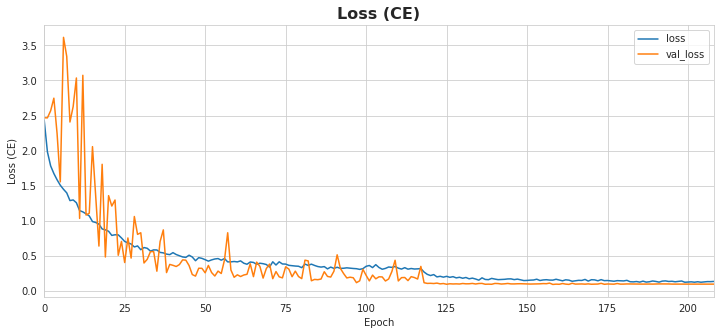

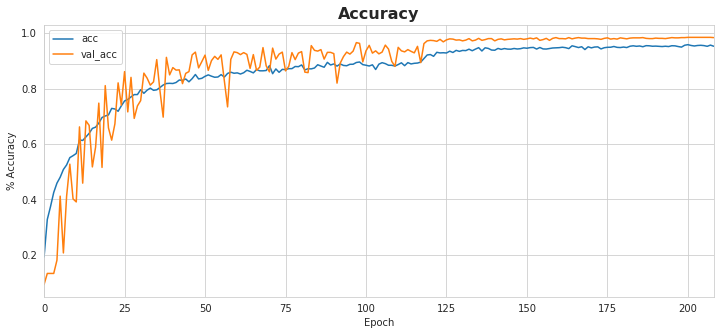

In [22]:
# Visualize mse
history_df = pd.DataFrame(desnet121_history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (CE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (CE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy")